In [1]:
import numpy as np
import pandas as pd 
import scanpy as sc
import utils
import mrf
import os 
import random 
import imp
import mrf
import time

SyntaxError: invalid syntax (mrf.py, line 81)

In [ ]:
imp.reload(mrf)

<module 'mrf' from '/home/qinxianhan/project/spatial/Hidden_Markov_Random_Field/src/mrf.py'>

In [ ]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(8,8))
import seaborn as sns

In [ ]:
adata = sc.read_visium('../../dataset/goldStandard')
adata.var_names_make_unique()
adata = utils.data_preprocess(adata)

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
from sklearn import mixture 
gmm = mixture.GaussianMixture(n_components=2)

In [19]:
coord = np.array(adata.obs.iloc[:,1:3])
target_list =['CAMK2N1', 'PCP4', 'NEFM', 'NEFH', 'B3GALT2']
target_gene =target_list[1]

In [83]:
beta =5
labels_list= mrf.mrf_process(adata, gene_id=target_gene, beta = beta,max_iteration=5e4)

77 121


100%|██████████| 50000/50000 [00:01<00:00, 45244.08it/s]

1029 pixels changed after 50000 iterations


In [ ]:
exp = adata[:,target_gene].X.toarray()
gmm = mixture.GaussianMixture(n_components=2)
gmm.fit(exp)
gmm_labels = gmm.predict(exp)

In [67]:
gmm.covariances_

array([[[3.54804567e-01]],

       [[1.00000000e-06]]])

In [32]:
from datetime import date
today = date.today()
today = today.strftime("%m_%d")
today

'10_23'

In [23]:
def label_reverse(labels_list):
    labels_list = np.array(labels_list)
    labels_list[labels_list==0]=2
    labels_list[labels_list==1]=0
    labels_list[labels_list==2]=1
    return labels_list

In [86]:
labels_list = label_reverse(labels_list)

In [85]:
output_dir = '../output/{}/'.format(today)
os.path.exists(output_dir) or os.makedirs(output_dir)

True

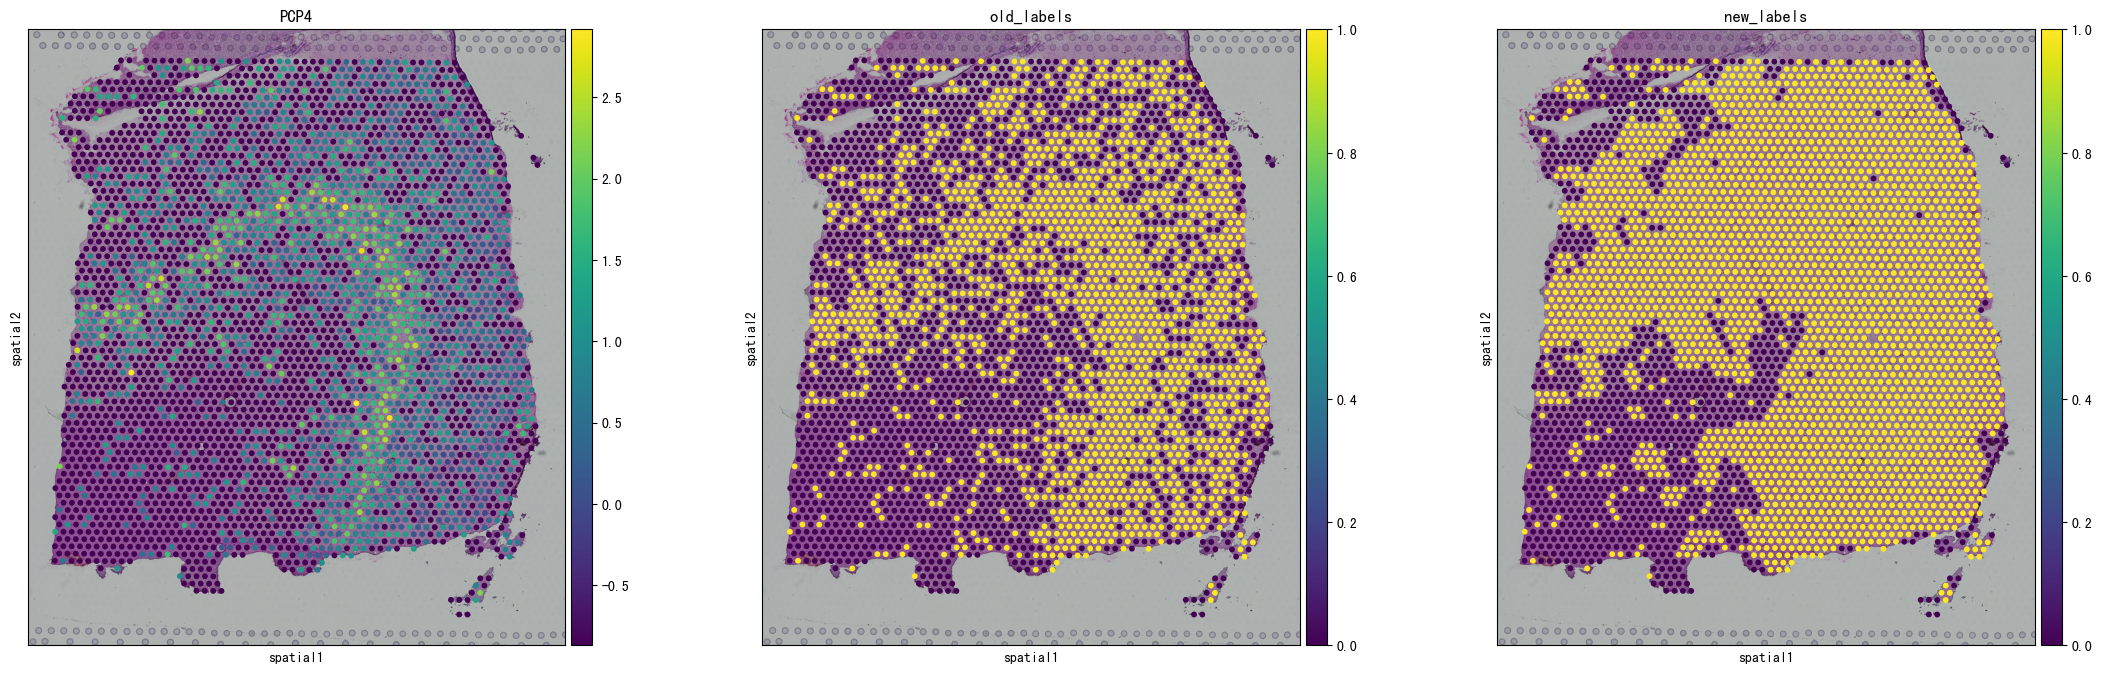

In [87]:
adata.obs['old_labels'] = gmm_labels
adata.obs['new_labels'] = labels_list
sc.pl.spatial(adata, color=[target_gene,'old_labels','new_labels'])

In [61]:
np.var([1,1,1,1,1])

0.0